In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from target import SingerModel
from simulation import simulate_on_trajectory, create_trajectory
from tracking import ResidualUpdatePolicy
from radar import MonostaticRadar

# Simulation description

The simulations will go as follows
1. Create trajectory using Singer model with constant sampling rate
2. Simulate Kalman filter on a given trajectory
3. Predictions for target state are given for each sampling instant
4. Obtain measurement in discrete time intervals determined by the update policy
5. Update Kalman filter predictions if measurement is obtained

## Target trajectories

1. Singer model <br>
    1.1 acceleration standard deviation and correlation is known <br>
    1.2 used in many references <br>
2. Jump-linear Markov system <br>
    2.1 Suits quite well for IMM estimators <br>
    2.2 Models more realistically real trajectories e.g. constant turns <br>
3. Benchmark trajectories <br>
    3.1 Can be used when comparing to other known results <br>
    3.2 Not as realistic since no process noise <br>

## Measurement models

- Factors that affect to signal-to-noise ratio
    - Target range
    - Angular prediction error (beam pointing direction)
    - Target RCS
    - Noise
- Probability of detection
    - SNR
    - False alarm probabilitiy
- Localization accuracy
    - SNR dependent
    - Defines measurement error standard deviation
    - Measurement noise defines the minimum MSE error that is possible to achieve between predictions and measurements
    - E.g. if predictions are perfect there will be still noise of standard deviation on the residuals
    - In radars the noise is along angular and radial components
- Radar load
    - dependent on probability of detection
    - revisit interval
    
### Signal-to-noise ratio

$\text{SNR} = \text{SN}_0 \exp \left( -2 \frac{(\alpha - \hat{\alpha})^2 + (\beta - \hat{\beta})^2}{B^2} \right)$

$\text{SN}_0 = \frac{P_\text{T} G_\text{T} G_\text{R} \lambda^2 \sigma}{(4\pi)^3 R^4 P_\text{N}}$


### Probability of detection model
$P_d$ = $P_f^{\frac{1}{1+\text{SNR}}}$


### Angular noise
$\sigma_\alpha = \frac{\theta_{\text{3dB}}}{k_m\sqrt{2\cdot\text{SNR}}}$


## Trackers

<IPython.core.display.Javascript object>


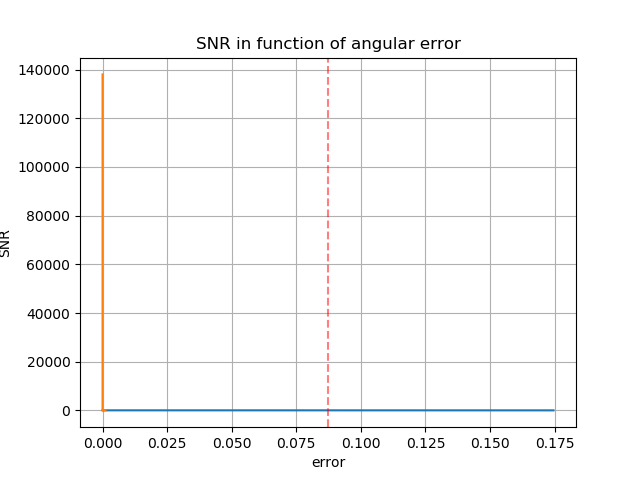

In [293]:
B = 5/180*np.pi
SN0 = 1000
error = (np.linspace(0, 10/180*np.pi))
snr = SN0*np.exp(-np.log(2) *error**2/(B**2))
plt.figure()
plt.plot(error, 10*np.log10(snr))
plt.axvline(x=B, color='r', linestyle='--', alpha=0.5)
plt.title('SNR in function of angular error')
plt.xlabel('error')
plt.ylabel('SNR')
plt.grid(True)

<IPython.core.display.Javascript object>


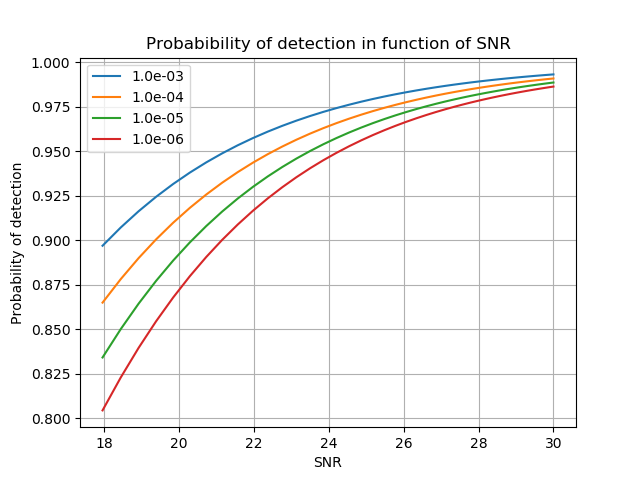

In [289]:
pfa_list = [1e-3, 1e-4, 1e-5, 1e-6]
plt.figure()
for pfa in pfa_list:
    pd = pfa**(1/(1+snr))
    plt.plot(10*np.log10(snr), pd, label='{:.1e}'.format(pfa))
plt.grid(True)
plt.xlabel('SNR')
plt.ylabel('Probability of detection')
plt.title('Probabibility of detection in function of SNR')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


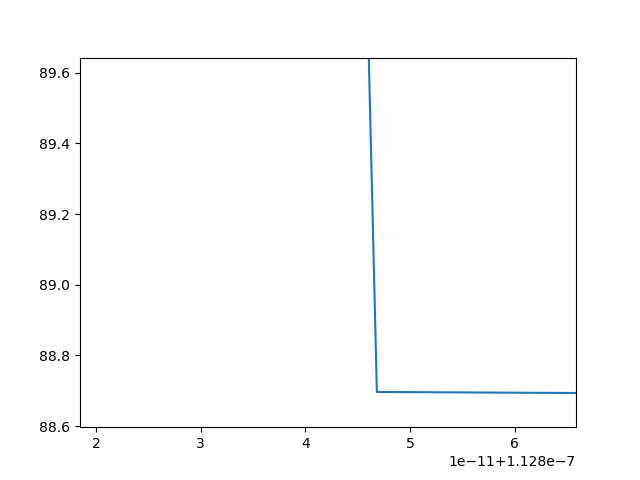

In [297]:
V0 = np.linspace(0.001, 1)
td = 0.01
tkeuk = 0.4*(V0*B)**(2.4) / (1 + 1/2 * (V0*B)**2)

L = td * np.exp(2*V0**2)/(SN0 * tkeuk)

plt.figure()
plt.plot(tkeuk, L)
plt.show()

<IPython.core.display.Javascript object>


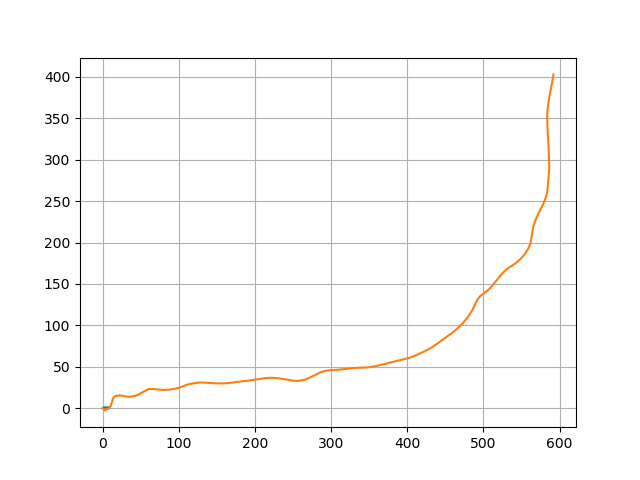

In [304]:
k = np.arange(1, 10)
plt.figure()
plt.plot(k, 1-(1-0.6)**k)
plt.grid(True)

In [313]:
k = np.arange(1, 1000)
pd = 0.9999
np.sum(k*(1-pd)**(k-1)*pd)-1/pd

0.0

# Run simulations

In [5]:
tracker = KalmanFilter(dim_x=3, dim_z=1)
target = SingerModel(1, 1, np.zeros(3))
update_policy = ResidualUpdatePolicy()
radar = MonostaticRadar(10, 0.0001, 2)

<IPython.core.display.Javascript object>


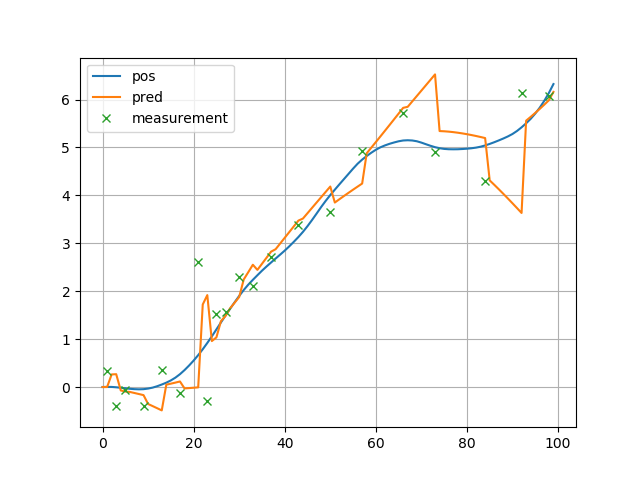

39.38829564911354

In [238]:
target.reset()
dt = 0.1
R = np.eye(1)
tracker.x = target.x
tracker.P = np.eye(3)
tracker.F = target.F(dt)
tracker.Q = target.Q(dt)
tracker.R = R
tracker.H = np.array([[1, 0, 0]])
update_policy.K = 1
N = 100

np.random.seed(2)
trajectory = create_trajectory(target, dt, N)
data = simulate_on_trajectory(trajectory, tracker, radar, update_policy)

plt.figure()
plt.plot(trajectory[:, 0], label='pos')
plt.plot(data['predictions'][:, 0], label='pred')
plt.plot(data['measurement_indexes'], data['measurements'], 'x', label='measurement')
plt.grid(True)
plt.legend()

<IPython.core.display.Javascript object>


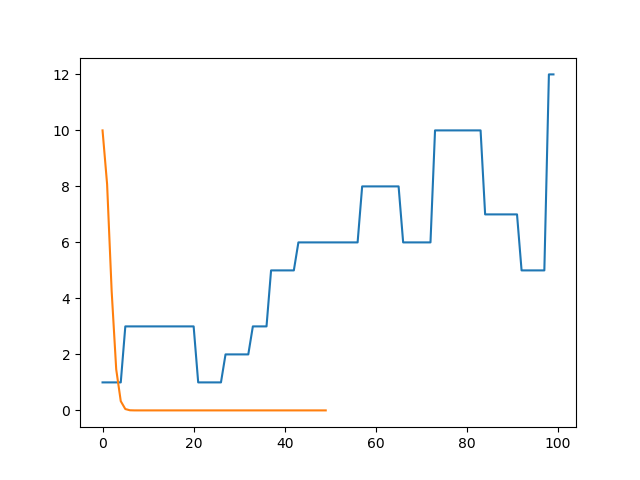

In [239]:
plt.figure()
plt.plot(data['intervals'])
plt.show()

In [ ]:
plt.figure()
plt.plot(np.abs(predictions[:,0]-states[:, 0]))

In [ ]:
plt.figure()
t = np.linspace(0.1, 4)
plt.plot(t, np.exp(t)/t)
plt.show()

In [258]:
np.log(2)

0.6931471805599453

# Complete simulation loop

1. Get target position
2. Calculate SN0
3. Calculate SNR using predicted angle coordinates
4. Calculate PD -> assume that the PD remains the same though the dwells
5. Simulate the dwell time (first expected later can be modified to stochastic)
6. return load
7. Calculate new interval for measurement
8. Obtain low-level updates and predictions in loop when interval is less than update interval
8. Return step one

In [345]:
power = 100e3
gain_transmit = 1
gain_receive = 1
wavelength = 0.15
rcs = 1
thermal_noise = 0.001
horizon = 1000
beamwidth = 5/180 * np.pi
pf = 1e-5
# simulation loop

trajectory1 = create_trajectory(target, dt, horizon)
trajectory2 = create_trajectory(target, dt, horizon)

positions = np.array([trajectory1[:, 0], trajectory2[:, 0]]).T

for t in range(horizon):
    pos = positions[t] # get positions
    
    angle_hat = 0  # get angle prediction
    angle = np.arctan(pos[1]/pos[0])
    R = np.linalg.norm(pos)
    SN0 = (power*gain_transmit*gain_receive*wavelength**2*rcs)/((4*np.pi)**3*R**4*thermal_noise)
    SNR = SN0 * np.exp(-2 * (angle_hat - angle)**2 / (beamwidth**2))
    Pd = pf**(1/(1+SNR))
    
    if True:
        dwell_time = 1/Pd
        load = dwell_time / interval
    else:
        pass

<IPython.core.display.Javascript object>


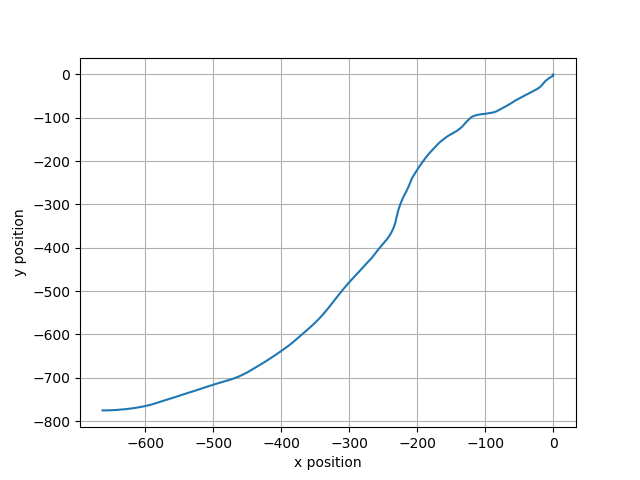

In [346]:
plt.figure()
plt.plot(positions[:, 0], positions[:, 1])
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)